<div align="right">
  Christopher Lüken-Winkels, Lukas Blecher
</div>
# Exercise 1b
## 3 Nearest Neighbor Classification on Real Data
### 3.1 Exploring the Data

In [66]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
import itertools
digits = load_digits ()
print ( digits.keys () )
data = digits ["data"]
images = digits ["images"]
target = digits ["target"]
target_names = digits ["target_names"]
print ( data.dtype )
#get an image of a random "3":
threes=images[target==3] #could also use data[index].reshape((8,8)) 
img=threes[np.random.randint(len(threes))]

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
float64


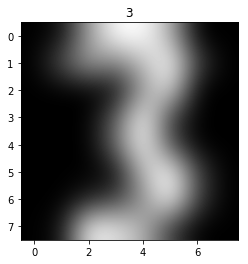

In [67]:
assert 2 == len( img.shape )
plt.figure ()
plt.gray ()
plt.imshow (img , interpolation ="bicubic") # also try interpolation =" bicubic "
plt.title('3')
plt.show ()

In [2]:
from sklearn import model_selection
X_all = data
y_all = target
X_train , X_test , y_train , y_test =\
model_selection.train_test_split ( digits.data , digits.target ,test_size = 0.4 , random_state = 0)

### 3.2 Distance function computation using loops
$$\text{dist:}\ {\rm I\!R}^{N \times D} \times {\rm I\!R}^{M \times D} \rightarrow {\rm I\!R}^{N \times M}$$ with $$N \text{: Length of training set}\\M \text{: Lenght of test set}\\D \text{: Number of pixels} = 64$$

In [68]:
def dist_loop(training, test):
    d=[] #save distances in this matrix
    #now: fill matrix line by line
    for i in range(len(training)):
        line=[] 
        #fill line for line with the distances
        for j in range(len(test)):
            line.append(np.sqrt(np.sum(np.square(test[j]-training[i]))))
        d.append(line)
    return np.array(d)

### 3.3 Distance function computation using vectorization

In [69]:
def dist_vec(training, test):
    #adding a new dimension to sum over (pixels) and calculate the difference to the test set in each instance
    return np.sqrt(np.sum(np.square(training[:,None]-test),axis=2))

In [12]:
%timeit dist_loop(X_test,X_train)

4.13 s ± 30.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit dist_vec(X_test,X_train)

392 ms ± 6.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
#check if both function even do the same
np.array_equal(dist_vec(X_test,X_train),dist_loop(X_test,X_train))

True

As we can see the vectorized solution is way faster than the looped version and gives the same result.

### 3.4 Implement the k-nearest neighbor classifier

In [70]:
#define the subset of X_train
subX_train=X_train[(y_train==3) | (y_train==9)] #only 3's and 9's are in the subsets
subX_test=X_test[(y_test==3) | (y_test==9)]
subY_train=y_train[(y_train==3) | (y_train==9)]
subY_test=y_test[(y_test==3) | (y_test==9)]

In [71]:
#nearest neighbor classifier
def NN(k,training,test,trainingLabel,testLabel):
    #calculate the distance matrix
    distance=dist_vec(training,test)
    guess=[]
    for i in range(len(test)):
        #get indices of smallest k distances of each column
        sorting=np.argsort(distance,axis=0).T[i][:k]
        #for only 3's and 9's we can look at the mean and check whether it is below or above (3+9)/2=6
        guess.append(3 if np.mean(trainingLabel[sorting])<6 else 9)
    error=1-np.count_nonzero(np.equal(guess,testLabel))/len(testLabel)
    return error,np.array(guess)

try for $k \in [ 1, 3, 5, 9, 17,33]$

In [72]:
err=[]
for k in [1,3,5,9,17,33]:
    errK,result=NN(k,subX_train,subX_test,subY_train,subY_test)
    err.append(errK)

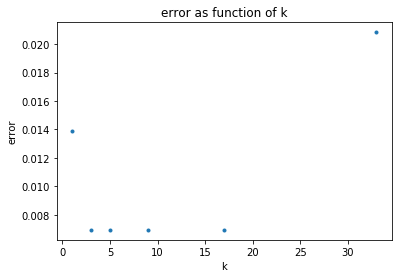

In [73]:
plt.plot([1,3,5,9,17,33],err,'.',label='error rate')
plt.xlabel('k')
plt.ylabel('error')
plt.title('error as function of k')
plt.show()

It performs very well. Only 1 to 3 wrong classifications for all $k$'s

### 4 Cross-validation

In [74]:
from numpy import random as rnd

def split_folds(data, target, L):   
    #shuffle target and data in unison
    permutation = rnd.permutation(len(data))
    data,target = data[permutation],target[permutation]
    return np.array_split(data,L),np.array_split(target,L)

In [114]:
def cross_val(data,target,L,k):   #CAREFUL: only works if len(data)%L == 0 (to be improved)
    #start list for error values
    Err = []
    #split data
    X_folds,Y_folds = split_folds(data,target,L)
    print(Y_folds.shape)
    #use each fold as test data once and the remaining folds as training set
    for i in range(L):
        X_test,Y_test = X_folds[i],Y_folds[i]
        X_train,Y_train = np.delete(X_folds,i,axis=0),np.delete(Y_folds,i) #training set without test set
        X_train=np.array(list(itertools.chain(*X_train)))
        err,guess = NN(k, X_train, X_test, Y_train, Y_test)
        Err.append(err)
    return np.mean(Err)

In [115]:
subX_all = X_all[(y_all==3) | (y_all==9)] #only 3's and 9's are in the subsets
suby_all = y_all[(y_all==3) | (y_all==9)]
cross_val(subX_all,suby_all,11,5)

AttributeError: 'list' object has no attribute 'shape'

In [206]:
X_folds,Y_folds = split_folds(subX_all,suby_all,5)
xt,yt=X_folds[0],Y_folds[0]
xtr,ytr=np.delete(X_folds,0,axis=0),np.delete(Y_folds,0)
#xtr=np.reshape(xtr,(xtr.shape[0]*xtr.shape[1],xtr.shape[2]))
print(xtr.shape,ytr.shape,xt.shape,yt.shape)
print(subX_train.shape,subY_train.shape,subX_test.shape,subY_test.shape)

(4,) (4,) (73, 64) (73,)
(219, 64) (219,) (144, 64) (144,)


In [34]:
a=np.array(range(30)).reshape((10,3))
b=np.array(range(10))
X_folds,Y_folds = split_folds(a,b,5)
xt,yt=X_folds[0],Y_folds[0]
xtr,ytr=np.delete(X_folds,0,axis=0),np.delete(Y_folds,0)
xtr=np.array(list(itertools.chain(*xtr)))
print(xt,'\n',yt,'\n\n',xtr,'\n\n',ytr)

[[15 16 17]
 [ 6  7  8]] 
 [5 2] 

 [[ 9 10 11]
 [ 3  4  5]
 [24 25 26]
 [21 22 23]
 [12 13 14]
 [27 28 29]
 [18 19 20]
 [ 0  1  2]] 

 [2 3 1 8 7 4 9 6 0]


In [87]:
data.shape

(1797, 64)